# [Pythonで画像からメインカラーを抽出する](https://qiita.com/simonritchie/items/396112fb8a10702a3644)

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc" style="margin-top: 1em;"><ul class="toc-item"><li><span><a href="#TL;DR" data-toc-modified-id="TL;DR-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>TL;DR</a></span></li><li><span><a href="#使うもの" data-toc-modified-id="使うもの-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>使うもの</a></span></li><li><span><a href="#サンプルデータ" data-toc-modified-id="サンプルデータ-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>サンプルデータ</a></span></li><li><span><a href="#スクリプト" data-toc-modified-id="スクリプト-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>スクリプト</a></span><ul class="toc-item"><li><span><a href="#画像の読み込みと変換" data-toc-modified-id="画像の読み込みと変換-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>画像の読み込みと変換</a></span></li><li><span><a href="#クラスタリング" data-toc-modified-id="クラスタリング-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>クラスタリング</a></span></li><li><span><a href="#色を表示してみる" data-toc-modified-id="色を表示してみる-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>色を表示してみる</a></span></li></ul></li><li><span><a href="#他の画像で試して見る" data-toc-modified-id="他の画像で試して見る-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>他の画像で試して見る</a></span></li><li><span><a href="#実行環境" data-toc-modified-id="実行環境-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>実行環境</a></span></li><li><span><a href="#参考サイト" data-toc-modified-id="参考サイト-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>参考サイト</a></span></li></ul></div>

# TL;DR

後で記載。

# 使うもの

- scikit-learn（k-means法）
- PIL、OpenCV（画像周り）

# サンプルデータ

元々はDCGANモデル検証でのイラストの色変換などのためのデータセットでカラーヒントを用意するためだったのですが、ここではフリー素材の写真を使ってみます。（イラスト側でも問題なく対応できるのは確認済み）

![KAZ7842_DSCF3133_TP_V.jpg](https://qiita-image-store.s3.amazonaws.com/0/228778/1d036a60-c528-8ee2-2204-bf6c8a3452ae.jpeg)

https://www.pakutaso.com/20160102025post-6676.html

![nuko-8_TP_V4.jpg](https://qiita-image-store.s3.amazonaws.com/0/228778/7e48d876-1ae5-30d6-d556-5d50f57d8eaa.jpeg)

https://www.pakutaso.com/20180234044post-15166.html

![kazuhiro17810000_TP_V.jpg](https://qiita-image-store.s3.amazonaws.com/0/228778/a5f24942-d751-f183-ab9d-b89e330697aa.jpeg)

https://www.pakutaso.com/20170835230post-12885.html

![rtethjdyrsetgshf_TP_V.jpg](https://qiita-image-store.s3.amazonaws.com/0/228778/ae37142c-333b-665c-1e7b-e569b96b4ab8.jpeg)

https://www.pakutaso.com/20170333074post-10666.html

In [ ]:
%%bash

#rm -f *.jpg
curl --output flower.jpg https://www.pakutaso.com/shared/img/thumb/KAZ7842_DSCF3133.jpg
curl --output cat.jpg https://www.pakutaso.com/shared/img/thumb/nuko-8.jpg
curl --output sky.jpg https://www.pakutaso.com/shared/img/thumb/kazuhiro17810000.jpg
curl --output buildings.jpg https://www.pakutaso.com/shared/img/thumb/rtethjdyrsetgshf.jpg


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1943k  100 1943k    0     0  4057k      0 --:--:-- --:--:-- --:--:-- 4048k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2049k  100 2049k    0     0  4314k      0 --:--:-- --:--:-- --:--:-- 4314k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 11.9M  100 11.9M    0     0  16.9M      0 --:--:-- --:--:-- --:--:-- 16.8M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 7056k  100 7056k    0     0  12.7M      0 --:--:-- --:--:-- --:--:-- 12.7M


# スクリプト

## 画像の読み込みと変換

花の画像を対象に進めていきます。

In [ ]:
import PIL

In [ ]:
from PIL import Image

In [ ]:
import cv2

In [ ]:
import sklearn

In [ ]:
from sklearn.cluster import KMeans

In [ ]:
cv2_img = cv2.imread('./flower.jpg')

OpenCV、読み込んだままだとカラーチャンネルの順番がRGBになっていないようなので変換をしておきます。

In [ ]:
cv2_img = cv2.cvtColor(cv2_img, cv2.COLOR_BGR2RGB)

処理の都合、(縦, 横, カラーチャンネル)の形式の画像のテンソルを、(縦と横をフラット化させた値, カラーチャンネル)の2次元の形式に変換しておきます。

In [ ]:
cv2_img.shape

(1969, 3500, 3)

In [ ]:
cv2_img = cv2_img.reshape(
    (cv2_img.shape[0] * cv2_img.shape[1], 3))

In [ ]:
cv2_img.shape

(6891500, 3)

## クラスタリング

k-means法でクラスタリングを行います。各ピクセルの色で、指定したクラスタ数でクラスタリングされ、その各クラスタの中央の座標の色をメインカラーとして扱います。

引数のn_clusterはクラスター数となります。今回はメインカラーを5色算出したいので、5を指定していますが、適宜調整してください。

In [ ]:
cluster = KMeans(n_clusters=5)

対象画像に対してクラスタリングを行います。画像サイズによっては少し時間がかかります。

In [ ]:
cluster.fit(X=cv2_img)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

cluster\_centers\_ という属性に、各クラスタの中央の値（RGBの値）が格納されます。

In [ ]:
cluster.cluster_centers_

array([[184.23426025,  93.7579373 ,  49.14172828],
       [ 64.45948869,  59.44007689,  85.47168488],
       [166.80113807, 211.94844333, 210.38880359],
       [102.42558417, 142.70389196, 168.89875457],
       [211.40822352, 238.8806729 , 231.275348  ]])

In [ ]:
cluster.cluster_centers_.shape

(5, 3)

クラスタ数を5にし、RGB3チャンネルの画像なので、(5, 3)の配列となりました。

## 色を表示してみる

RGBの配列だとイメージがつきづらいので、PILを使って単色画像でそれぞれ表示してみます。

Pythonでは、02xと指定することで、0～255までの値を16進数の00～ffのフォーマットにしてくれるので、それを使って#ffffffといった文字列を用意してPILに渡します。

In [ ]:
format(255, '02x')

'ff'

In [ ]:
'#%02x%02x%02x' % (255, 255, 255)

'#ffffff'

浮動小数点数は不要なので、キャストしておきます。（16進数変換の都合）

In [ ]:
cluster_centers_arr = cluster.cluster_centers_.astype(
    int, copy=False)

ループで回す都合、Jupyter上で全ての画像を表示するためにdisplay関数を使用します。（そのままだと最後の画像しか、アウトプットとして表示されないため）

In [ ]:
from IPython.display import display

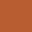

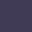

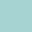

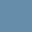

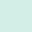

In [ ]:
for rgb_arr in cluster_centers_arr:
    color_hex_str = '#%02x%02x%02x' % tuple(rgb_arr)
    color_img = Image.new(
        mode='RGB', size=(32, 32), color=color_hex_str)
    display(color_img)

元画像を表示してみて、比較してみます。

In [ ]:
original_img = Image.open('./flower.jpg')

In [ ]:
original_img.size

(3500, 1969)

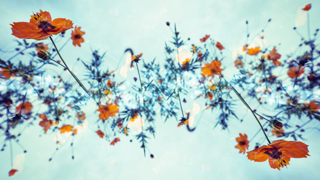

In [ ]:
original_img.resize((320, 180))

いい感じです。

おまけで、PILを使って背景をグレーにし、横並びの画像を作ってみます。

In [ ]:
# 幅と高さ64px × 横並び5画像 + 上下左右余白15pxずつの画像を作ります。
IMG_SIZE = 64
MARGIN = 15
width = IMG_SIZE * 5 + MARGIN * 2
height = IMG_SIZE + MARGIN * 2
print(width, height)

350 94


In [ ]:
tiled_color_img = Image.new(
    mode='RGB', size=(width, height), color='#333333')

この段階では上記の用意した画像は、グレーの横長画像です。

この画像に、各クラスタの色の画像をペーストしていきます。PILのpaste関数を使います。引数のboxで、左の余白値、上の余白値といった具合でペーストする位置を設定できるので、ループのインデックスを加味して位置を指定します。

Pythonでループのインデックスを取りたい場合には、enumerate関数を使うとindex, valueといった形で扱えるのでシンプルです。

In [ ]:
for i, rgb_arr in enumerate(cluster_centers_arr):
    color_hex_str = '#%02x%02x%02x' % tuple(rgb_arr)
    color_img = Image.new(
        mode='RGB', size=(IMG_SIZE, IMG_SIZE),
        color=color_hex_str)
    tiled_color_img.paste(
        im=color_img,
        box=(MARGIN + IMG_SIZE * i, MARGIN))

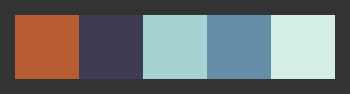

In [ ]:
tiled_color_img

Adobe Color CCの探索画面みたいなカラーセットを用意することができました。

# 他の画像で試して見る

関数化して、他の写真でも試してみましょう。

In [ ]:
def get_main_color_list_img(img_path):
    """
    対象の画像のメインカラーを算出し、色を横並びにしたPILの画像を取得する。
    
    Parameters
    ----------
    img_path : str
        対象の画像のパス。
    
    Returns
    -------
    tiled_color_img : Image
        色を横並びにしたPILの画像。
    """
    cv2_img = cv2.imread(img_path)
    cv2_img = cv2.cvtColor(cv2_img, cv2.COLOR_BGR2RGB)
    cv2_img = cv2_img.reshape(
        (cv2_img.shape[0] * cv2_img.shape[1], 3))
    
    cluster = KMeans(n_clusters=5)
    cluster.fit(X=cv2_img)
    cluster_centers_arr = cluster.cluster_centers_.astype(
        int, copy=False)
    
    IMG_SIZE = 64
    MARGIN = 15
    width = IMG_SIZE * 5 + MARGIN * 2
    height = IMG_SIZE + MARGIN * 2
    
    tiled_color_img = Image.new(
        mode='RGB', size=(width, height), color='#333333')
    
    for i, rgb_arr in enumerate(cluster_centers_arr):
        color_hex_str = '#%02x%02x%02x' % tuple(rgb_arr)
        color_img = Image.new(
            mode='RGB', size=(IMG_SIZE, IMG_SIZE),
            color=color_hex_str)
        tiled_color_img.paste(
            im=color_img,
            box=(MARGIN + IMG_SIZE * i, MARGIN))
    return tiled_color_img

In [ ]:
def get_original_small_img(img_path):
    """
    元画像の小さくリサイズしたPILの画像を取得する。
    
    Parameters
    ----------
    img_path : str
        対象の画像のパス。
    
    Returns
    -------
    img : Image
        リサイズ後の画像。
    """
    img = Image.open(fp=img_path)
    width = int(img.size[0] / 5)
    height = int(img.size[1] / 5)
    img = img.resize(size=(width, height))
    return img

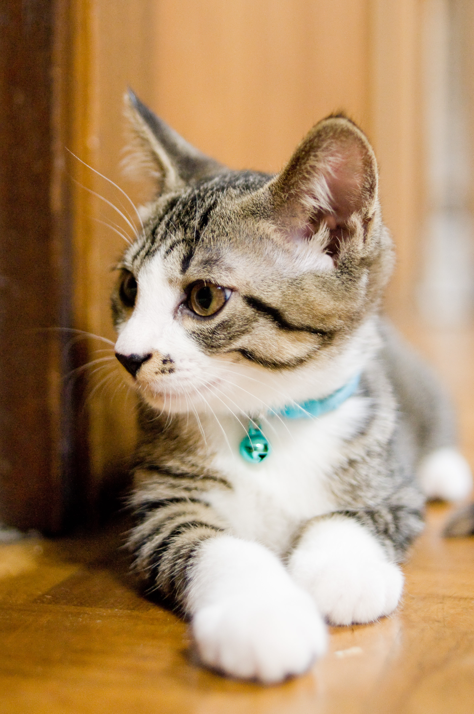

In [ ]:
get_original_small_img(img_path='./cat.jpg')

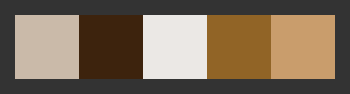

In [ ]:
get_main_color_list_img(img_path='./cat.jpg')

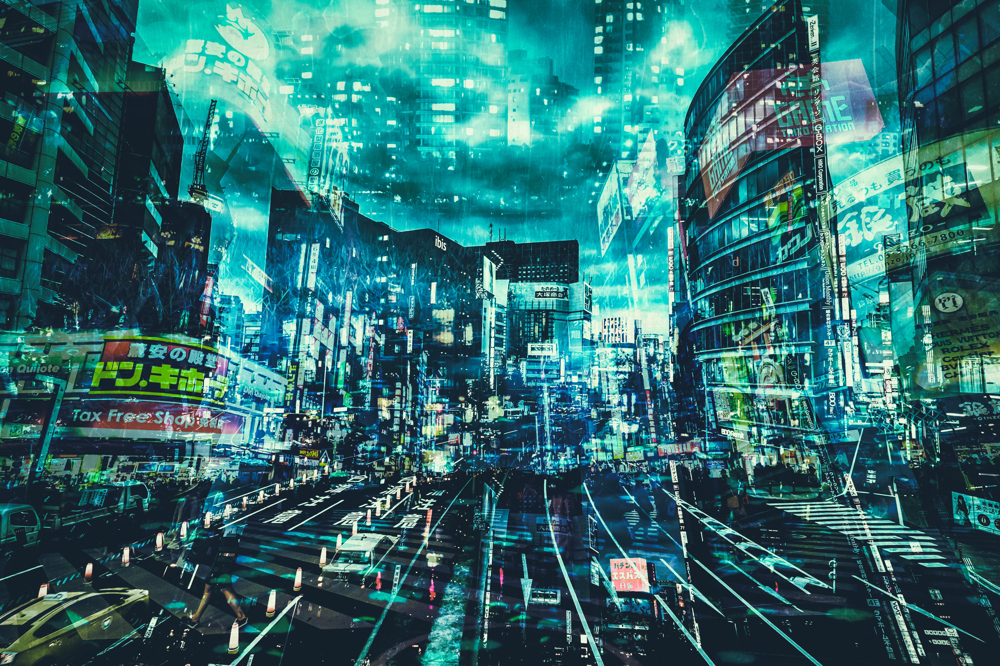

In [ ]:
get_original_small_img(img_path='./sky.jpg')

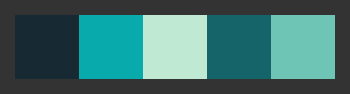

In [ ]:
get_main_color_list_img(img_path='./sky.jpg')

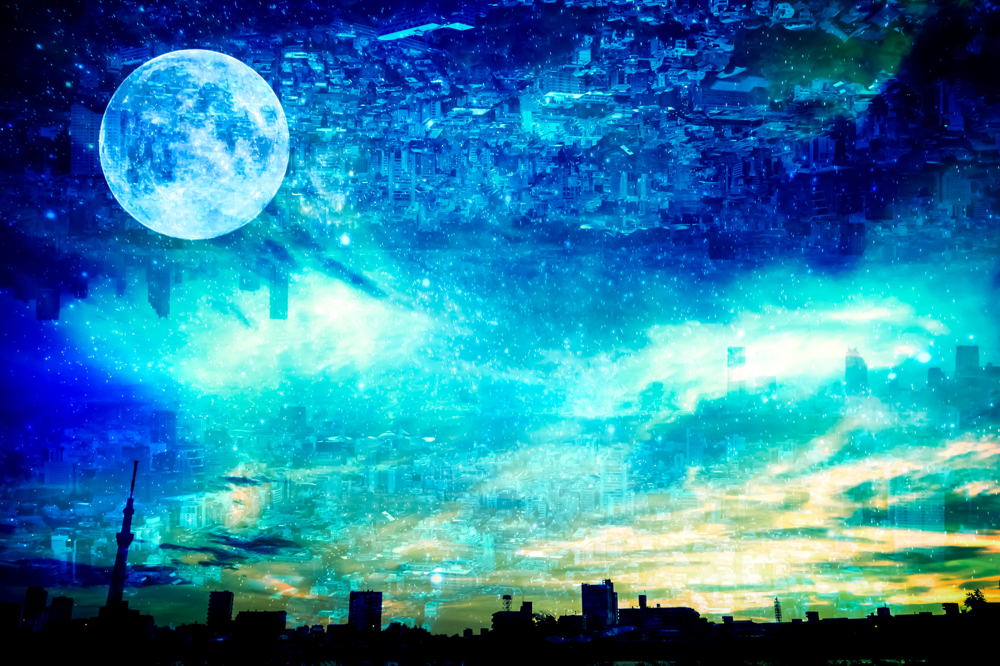

In [ ]:
get_original_small_img(img_path='./buildings.jpg')

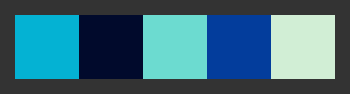

In [ ]:
get_main_color_list_img(img_path='./buildings.jpg')

# 実行環境

- Azure Notebooks

In [ ]:
!python -V

Python 3.7.10


In [ ]:
PIL.__version__

'7.1.2'

In [ ]:
cv2.__version__

'4.1.2'

In [ ]:
sklearn.__version__

'0.22.2.post1'

# 参考サイト

[OpenCV and Python K-Means Color Clustering](https://www.pyimagesearch.com/2014/05/26/opencv-python-k-means-color-clustering/)